In [1]:
"""
Reference: 
  Logging: https://youtu.be/G7GH0SeNBMA
  Tables: https://youtu.be/K6l62U0fAng
"""

'\nReference: \n  Logging: https://youtu.be/G7GH0SeNBMA\n  Tables: https://youtu.be/K6l62U0fAng\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Why?

# What?

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{pytorch-video} -->


<div><img /></div>

<img src="https://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />

<div><img /></div>



# Content


* Overview of Model used
* Setup WandB
* Logging 
  * Config (Why important)  
  * Gradients
  * Loss & Accuracy
* Saving Model
* Analysis
  * Plots
  * Comparison b/w runs
  * Table



# Import libs

In [3]:
# ✨ W&B: installing wandb
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

In [5]:
# ✨ W&B: import and authorize
import wandb
# wandb.login()
wandb.login(key='885289608c38cb92b32f05f0258264d5aca35b37')

# ✨ W&B: command different way to authorize for scripts, etc
# wandb.login(key=local_key)
# wandb.join()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khushdev20211 (cv_assignment). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
from google.colab import drive
# drive.mount("/content/gdrive")
drive.mount("/content/drive")
path_data = "/content/drive/MyDrive/ECE344: CV (Computer Vision)/Refresher-Module/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


# **Dataset Formation**

In [8]:
train_size = int(2000*0.7)
test_size = int(2000*0.15)
val_size = int(2000*0.15)

In [9]:
g = torch.Generator()
g.manual_seed(42)

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((64, 64))])

batch_size = 64

dataset = torchvision.datasets.ImageFolder(
    root=path_data,
    transform=transform
)
dataset_size = len(dataset)

indices = list(range(dataset_size))
np.random.shuffle(indices)

test_index = indices[:test_size]
train_index = indices[test_size:test_size+train_size]
val_index = indices[-val_size:]

train_sampler=SubsetRandomSampler(train_index, generator=g)
val_sampler=SubsetRandomSampler(val_index, generator=g)
test_sampler=SubsetRandomSampler(test_index, generator=g)

trainloader = torch.utils.data.DataLoader(dataset, sampler = train_sampler, batch_size=batch_size,num_workers=2)
valloader = torch.utils.data.DataLoader(dataset, sampler = val_sampler, batch_size=batch_size,num_workers=2)
testloader = torch.utils.data.DataLoader(dataset, sampler = test_sampler, batch_size=batch_size,num_workers=2)

dataset.class_to_idx

{'Parasitized': 0, 'Uninfected': 1}

In [11]:
print("Length of train: ", len(train_index))
print("Length of val: ", len(val_index))
print("Length of test: ", len(test_index))

Length of train:  1400
Length of val:  300
Length of test:  300


In [12]:
dataset_size

2000

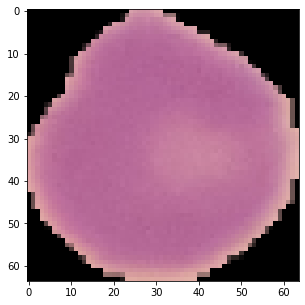

tensor(1)


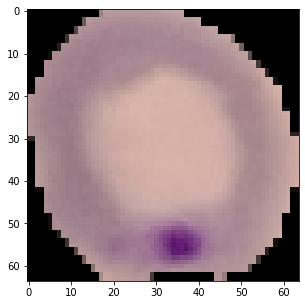

tensor(0)


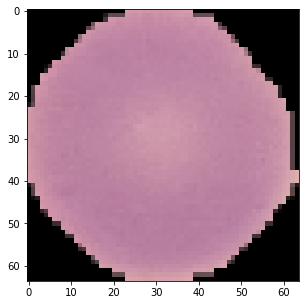

tensor(1)


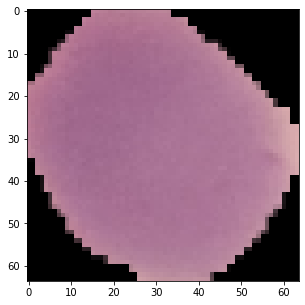

tensor(1)


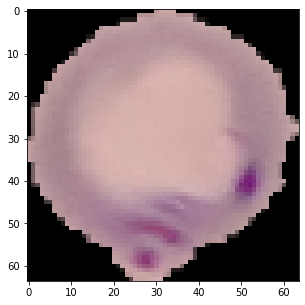

tensor(0)


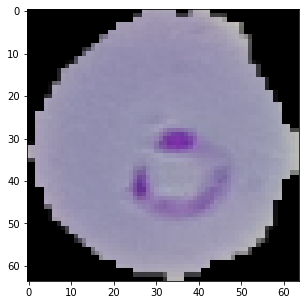

tensor(0)


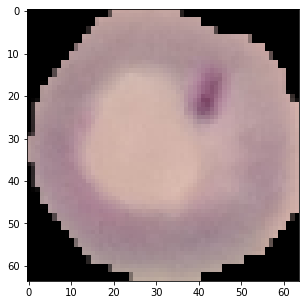

tensor(0)


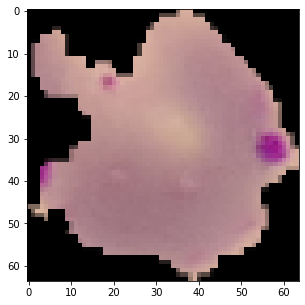

tensor(0)


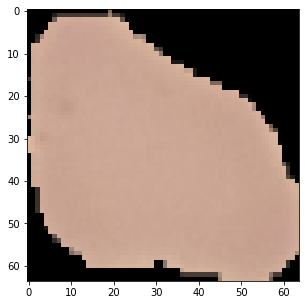

tensor(1)


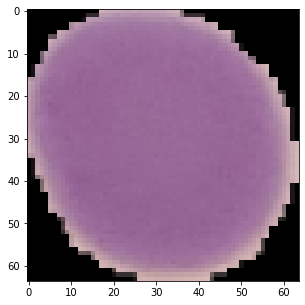

tensor(1)


In [13]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

def imshow(img):
    plt.figure(figsize=(5, 5))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i in range(10):
  imshow(images[i])
  print(labels[i])

### **Defining the model architecture**

In [14]:
class Model(nn.Module):
    def __init__(self,mode="default",drops="none"):
      
        super().__init__()

        #conv2d main args = in_channel, out_channel, kernel size, stride, padding
        #MaxPool2d main args = kernel size, stride

        self.conv1 = nn.Conv2d(3, 5, 9)
        self.conv2 = nn.Conv2d(5, 7, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(7, 10, 3)
        self.fc1 = nn.Linear(10 * 23 * 23, 1)
        self.drop = nn.Dropout2d(0.2)
        self.sig = nn.Sigmoid()
        self.drops = drops

        if mode=="Zero":
          torch.nn.init.zeros_(self.conv1.weight)
          torch.nn.init.zeros_(self.conv2.weight)
          torch.nn.init.zeros_(self.conv3.weight)
          torch.nn.init.zeros_(self.fc1.weight)


        elif mode=="Random":
          torch.nn.init.normal_(self.conv1.weight)
          torch.nn.init.normal_(self.conv2.weight)
          torch.nn.init.normal_(self.conv3.weight)
          torch.nn.init.normal_(self.fc1.weight)

        elif mode=="He":
          torch.nn.init.kaiming_uniform_(self.conv1.weight)
          torch.nn.init.kaiming_uniform_(self.conv2.weight)
          torch.nn.init.kaiming_uniform_(self.conv3.weight)
          torch.nn.init.kaiming_uniform_(self.fc1.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(self.conv2(x))
        x = self.conv3(x)
        
        if self.drops=="after_conv":
          x = self.drop(x)
        x = torch.flatten(x, 1) 
        x = self.fc1(x)

        if self.drops=="after_fc":
          x = self.drop(x)
        
        return self.sig(x)
      
    def get_features(self, x):
        x = self.conv1(x)
        x = self.pool(self.conv2(x))
        x = self.conv3(x)
        
        x = torch.flatten(x, 1) 
        return x
      
    def get_outs(self, x):

        x = self.conv1(x)
        y = self.pool(self.conv2(x))
        z = self.conv3(y)

        return x,y,z

    
def my_loss(outputs,labels):
  loss = torch.mean(-labels*torch.log(outputs)-(1-labels)*torch.log((1-outputs)))
  return loss
    

# **Optimizer and Loss function**

In [15]:
criterion =  my_loss
lr=0.001
epochs=10
model = Model("He").to(device)
wd = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# WandB

In [16]:
# ✨ W&B: command to initialise the run
wandb.init(entity="cv_assignment", project="wandb-tutorial",name="baseline")  ## entity is teamname 
# wandb.init(entity="cv_assignment", project="wandb-tutorial",name="with_regularization")  ## entity is teamname 

# ✨ W&B: command to add config to the run
wandb.config = {"learning_rate": lr , "epochs": epochs, "batch_size": batch_size}  ## config is to store the config of current run in wandb, makes it easier to keep track of different runs
# wandb.config = {"learning_rate": lr , "epochs": epochs, "batch_size": batch_size, 'wd':wd} 


# **Training and testing on validation set**

In [17]:
total_loss_train = []
total_loss_validation = []
lambda1=0.5

## command to log gradients to wandb
wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis

for epoch in range(epochs):  
    print(epoch + 1)
    
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.reshape(-1,1)
        labels=labels.float()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        # print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1

    batch_loss_train/=num_batches
    print("Trianing Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    
    # Valdiation Loop
    with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 32
      for data in valloader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          labels = labels.float()
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          predicted = [1 if x>0.5 else 0 for x in outputs]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
      wandb.log(
          {"accuracy" : acc , "Train_loss":batch_loss_train, "Val_loss": batch_loss_val}
          )

      print("Validation loss is ",batch_loss_val/cnt)
      print("Validation Acc is ", acc)

print('Finished Training')

1
Trianing Loss  0.9076635512438688
Validation loss is  0.7824972629547119
Validation Acc is  59.666666666666664
2
Trianing Loss  0.59183100678704
Validation loss is  0.8703648328781128
Validation Acc is  69.66666666666667
3
Trianing Loss  0.5408015738834034
Validation loss is  0.8932032585144043
Validation Acc is  69.0
4
Trianing Loss  0.5345920446244153
Validation loss is  0.9302116632461548
Validation Acc is  64.33333333333333
5
Trianing Loss  0.5193502374670722
Validation loss is  0.9151497602462768
Validation Acc is  67.0
6
Trianing Loss  0.49235380508682947
Validation loss is  0.9035502672195435
Validation Acc is  69.0
7
Trianing Loss  0.4543492550199682
Validation loss is  0.9610722661018372
Validation Acc is  70.66666666666667
8
Trianing Loss  0.44515893811529333
Validation loss is  1.0204028844833375
Validation Acc is  70.33333333333333
9
Trianing Loss  0.43009535426443274
Validation loss is  1.012996292114258
Validation Acc is  68.33333333333333
10
Trianing Loss  0.4113308231

In [18]:
# ✨ W&B: Save Model
torch.save(model.state_dict(),"model.pth")
artifact = wandb.Artifact('model', type='model')
artifact.add_file('model.pth')
wandb.log_artifact(artifact)

In [19]:
# ✨ W&B: Mark the run as complete (useful for multi-cell notebook)
wandb.finish()

Train_loss,█▄▃▃▃▂▂▁▁▁
Val_loss,▁▄▄▅▅▅▆███
accuracy,▁▇▇▄▆▇██▇▆
Train_loss,0.41133
Val_loss,5.04817
accuracy,67.66667


# **loss plots**

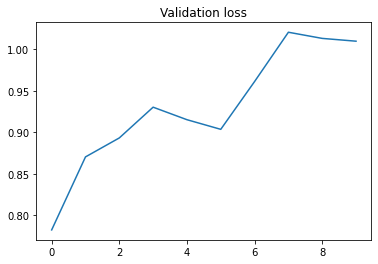

In [20]:
import matplotlib.pyplot as plt
plt.plot(total_loss_validation)
plt.title("Validation loss")
plt.show()

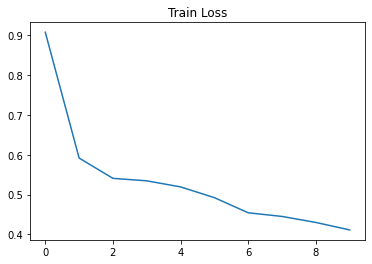

In [21]:
plt.plot(total_loss_train)
plt.title("Train Loss")
plt.show()

# WandB Tables

In [22]:
# resume run
wandb.init(entity="cv_assignment",name="baseline",project="wandb-tutorial",id="rxeqtlcd", resume="must",settings=wandb.Settings(start_method="thread"))

In [23]:
#download model
artifact = wandb.use_artifact('cv_assignment/wandb-tutorial/model:v0', type='model')
artifact_dir = artifact.download() 


wandb:   1 of 1 files downloaded.  


In [24]:
# load model
model = Model("He").to(device)
state_dict = torch.load(artifact_dir+"/model.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
# ✨ W&B: Create a Table to store predictions for each test step
columns=["id", "image", "prediction", "truth","confidence"]
val_table = wandb.Table(columns=columns)

In [26]:
# ✨ W&B: Log Table

def log_validation_predictions(images, labels, scores, predicted, val_table, log_counter):
  log_scores = scores.cpu().numpy()
  log_images = images.cpu().numpy()
  log_labels = labels.cpu().numpy()
  log_preds = predicted.cpu().numpy()
  # adding ids based on the order of the images
  _id = 0
  for i, l, p, s in zip(log_images, log_labels, log_preds, log_scores):
    # add required info to data table:
    # id, image pixels, model's guess, true label, scores for all classes
    img_id = str(_id) + "_" + str(log_counter)
    i = i.transpose((1,2,0))
    val_table.add_data(img_id, wandb.Image(i), p, l, *s)
    _id += 1
    if _id == NUM_IMAGES_PER_BATCH:
      break

In [27]:
# Valdiation Loop
batch_loss_val=0
with torch.no_grad():
  correct = 0
  total = 0
  cnt=0
  # ✨ W&B: parameters
  log_counter = 0
  NUM_BATCHES_TO_LOG = 10
  NUM_IMAGES_PER_BATCH = 32
  for data in valloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Get Prediction
      outputs = model(inputs)

      # Compute loss 
      total += labels.size(0)
      cnt+=1
      labels = labels.float()
      loss_val = criterion(outputs, labels)
      batch_loss_val += loss_val.item()
      predicted = [1 if x>0.5 else 0 for x in outputs]
      predicted = torch.Tensor(predicted).to(device)
      correct += (predicted == labels).sum().item()

      # ✨ W&B: Log Table 
      if log_counter < NUM_BATCHES_TO_LOG:
        log_validation_predictions(inputs, labels, outputs, predicted, val_table, log_counter)
        log_counter += 1

  acc = 100 * correct / total

  # ✨ W&B: Log predictions table to wandb
  wandb.log({"Validation_predictions" : val_table})


  print("Validation loss is ",batch_loss_val/cnt)
  print("Validation Acc is ", acc)

Validation loss is  1.1688021421432495
Validation Acc is  84.0


In [28]:
wandb.finish()

Train_loss,0.34653
Val_loss,5.9752
accuracy,70.66667
